In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd


In [11]:
dataset = pd.read_csv('C:/Users/user/Downloads/딥러닝_파이토치_교과서_예제파일_(2)/chap02/data/car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<Axes: ylabel='count'>

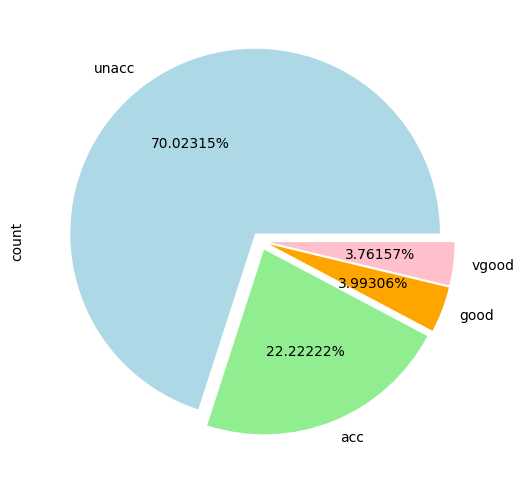

In [13]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%',
                                  colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode = (0.05, 0.05, 0.05, 0.05))

In [15]:
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns :
    dataset[category] = dataset[category].astype('category')

price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [17]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [19]:
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


In [20]:
categorical_column_sizes = [len(dataset[column].cat. categories) for column in
categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in
categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [22]:
total_records = 1728
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [23]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [29]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni,
                                         nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers =[]
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols
        
        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i
        
        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

def forward(self, x_categorical):
    embeddings =[]
    for i,e in enumerate(self.all_embeddings):
        embeddings.append(e(x_categorical[:, i]))
        x = torch. cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

In [30]:
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [31]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
if torch.cuda.is_available():
    device = torch.device('gpu')
else:
    device = torch.device('cpu')

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

# ┌───────────────────────────────────┐
# │ 1) Model 정의 (forward() 필수!)  │
# └───────────────────────────────────┘
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    # ← 반드시 구현해야 호출이 가능합니다!
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ┌───────────────────────────────────┐
# │ 2) 데이터 & 하이퍼파라미터 세팅 │
# └───────────────────────────────────┘
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 예시: categorical_train_data, train_outputs 가 이미 준비되어 있다고 가정
# categorical_train_data: (N × input_dim) tensor, float32
# train_outputs         : (N,)            tensor, integer class labels

input_dim  = categorical_train_data.shape[1]
hidden_dim = 64
output_dim = train_outputs.unique().numel()
lr         = 1e-3

model         = Model(input_dim, hidden_dim, output_dim).to(device)
optimizer     = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

# 장치(device)로 데이터 옮기기
categorical_train_data = categorical_train_data.to(device=device, dtype=torch.float32)
train_outputs          = train_outputs.to(device=device, dtype=torch.int64)

# ┌───────────────────────────────────┐
# │ 3) 훈련 루프 (코드 2‑14 스타일) │
# └───────────────────────────────────┘
epochs = 500
aggregated_losses = []

for i in range(1, epochs + 1):          # i = 1,2,…,500
    # 1) 순전파
    y_pred = model(categorical_train_data)

    # 2) 손실 계산
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss.item())

    # 3) 25 에폭마다 로그 출력
    if i % 25 == 1:
        print(f'epoch: {i:3d}  loss: {single_loss.item():10.8f}')

    # 4) 역전파 & 파라미터 업데이트
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

# ┌───────────────────────────────────┐
# │ 4) 최종 손실 출력                │
# └───────────────────────────────────┘
print(f'epoch: {i:3d}  loss: {single_loss.item():10.10f}')


epoch:   1  loss: 0.67755991
epoch:  26  loss: 0.57204509
epoch:  51  loss: 0.56302679
epoch:  76  loss: 0.55992711
epoch: 101  loss: 0.55769265
epoch: 126  loss: 0.55565262
epoch: 151  loss: 0.55292112
epoch: 176  loss: 0.54982597
epoch: 201  loss: 0.54663175
epoch: 226  loss: 0.54326373
epoch: 251  loss: 0.53958970
epoch: 276  loss: 0.53579116
epoch: 301  loss: 0.53174549
epoch: 326  loss: 0.52721512
epoch: 351  loss: 0.52215296
epoch: 376  loss: 0.51603550
epoch: 401  loss: 0.51009250
epoch: 426  loss: 0.50325316
epoch: 451  loss: 0.49504897
epoch: 476  loss: 0.48725981
epoch: 500  loss: 0.4800985754


In [41]:
# 1) 평가 모드 전환 (드롭아웃·배치정규화 있는 경우 필수)
model.eval()

# 2) 입력과 레이블을 device + 올바른 dtype으로 옮기기
categorical_test_data = categorical_test_data.to(device=device, dtype=torch.float32)
test_outputs           = test_outputs.to(device=device,      dtype=torch.int64)

# 3) 순전파만 수행
with torch.no_grad():
    y_val = model(categorical_test_data)              # 이제 float32 입력 → 에러 사라짐
    loss  = loss_function(y_val, test_outputs)

# 4) 스칼라 값 꺼내서 출력
print(f'Loss: {loss.item():.8f}')

Loss: 0.52355051


In [42]:
print(y_val[:5])

tensor([[ 0.5294, -0.9562],
        [ 0.6404, -1.0805],
        [ 0.5550, -0.9046],
        [ 0.1555, -0.5721],
        [ 0.3583, -0.6759]])


In [43]:
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs, y_val))

[[259   0]
 [ 81   5]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       259
           1       1.00      0.06      0.11        86

    accuracy                           0.77       345
   macro avg       0.88      0.53      0.49       345
weighted avg       0.82      0.77      0.68       345

0.7652173913043478
